In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Datasets: ISBI 2012 EM Segmentation Challenge 
# Most of the codes are from Dacon_Unet_implement 
# 

In [ ]:

import os
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class Unet_modified(nn.Module):

    def __init__(self):
        super().__init__()

        def Layer_repeated(in_channels,out_channels,
                  kernel_size = 3,stride = 1,padding = 1,bias = True):
            
            block = []

            block +=  [nn.Conv2d(in_channels=in_channels, 
                                 out_channels=out_channels,
                                 kernel_size=kernel_size, 
                                 stride=stride, 
                                 padding=padding,
                                 bias=bias)]
            block += [nn.BatchNorm2d(num_features = out_channels)]

            block += [nn.ReLU()]

            res = nn.Sequential(*block)

            return res 
        
        #contract_layers 
        self.contract_layer1_1 =  Layer_repeated(in_channels=1, out_channels=64)
        self.contract_layer1_2 =  Layer_repeated(in_channels=64, out_channels=64)
        
        self.pooling_layer_1 = nn.MaxPool2d(kernel_size = 2)
        
        self.contract_layer2_1 =  Layer_repeated(in_channels=64, out_channels=128)
        self.contract_layer2_2 =  Layer_repeated(in_channels=128, out_channels=128)
       
        self.pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        
        self.contract_layer3_1 =  Layer_repeated(in_channels=128, out_channels=256)
        self.contract_layer3_2 =  Layer_repeated(in_channels=256, out_channels=256)

        self.pooling_layer_3 = nn.MaxPool2d(kernel_size = 2)

        self.contract_layer4_1 =  Layer_repeated(in_channels = 256, out_channels = 512)
        self.contract_layer4_2 =  Layer_repeated(in_channels = 512, out_channels = 512)

        self.pooling_layer_4 = nn.MaxPool2d(kernel_size = 2)

        self.contract_layer5_1 =  Layer_repeated(in_channels = 512, out_channels = 1024)


        #Exapansive Layer 

        self.expand_layer5_1 = Layer_repeated(in_channels = 1024, out_channels = 512)

        self.unpooling_layer_4 = nn.ConvTranspose2d(in_channels = 512,
                                                    out_channels = 512,
                                                    kernel_size = 2,
                                                    stride = 2,
                                                    padding = 0,
                                                    bias = True)
        
        self.expand_layer4_2 = Layer_repeated(in_channels = 1024, out_channels = 512)

        self.expand_layer4_1 = Layer_repeated(in_channels = 512, out_channels = 256)

        self.unpooling_layer_3 = nn.ConvTranspose2d(in_channels = 256,
                                                    out_channels = 256,
                                                    kernel_size = 2,
                                                    stride = 2,
                                                    padding = 0,
                                                    bias = True)
        
        self.expand_layer3_2 = Layer_repeated(in_channels = 512, out_channels = 256)

        self.expand_layer3_1 = Layer_repeated(in_channels = 256, out_channels = 128)

        self.unpooling_layer_2 = nn.ConvTranspose2d(in_channels = 128,
                                                    out_channels = 128,
                                                    kernel_size = 2,
                                                    stride = 2,
                                                    padding = 0,
                                                    bias = True)
        
        self.expand_layer2_2 = Layer_repeated(in_channels = 256, out_channels = 128)

        self.expand_layer2_1 = Layer_repeated(in_channels = 128, out_channels = 64)

        self.unpooling_layer_1 = nn.ConvTranspose2d(in_channels = 64,
                                                    out_channels = 64,
                                                    kernel_size = 2,
                                                    stride = 2,
                                                    padding = 0,
                                                    bias = True)
        
        self.expand_layer1_2 = Layer_repeated(in_channels = 128, out_channels = 64)

        self.expand_layer1_1 = Layer_repeated(in_channels = 64, out_channels = 64)

        self.fc = nn.Conv2d(in_channels = 64,
                            out_channels = 1,
                            kernel_size=1 ,
                            stride = 1,
                            padding = 0,
                            bias = True)
    
    def forward(self,x):

        enc1_1 = self.contract_layer1_1(x)
        enc1_2 = self.contract_layer1_2(enc1_1)
        pool1 = self.pooling_layer_1(enc1_2)

        enc2_1 = self.contract_layer2_1(pool1)
        enc2_2 = self.contract_layer2_2(enc2_1)
        pool2 = self.pooling_layer_2(enc2_2)

        enc3_1 = self.contract_layer3_1(pool2)
        enc3_2 = self.contract_layer3_2(enc3_1)
        pool3 = self.pooling_layer_3(enc3_2)

        enc4_1 = self.contract_layer4_1(pool3)
        enc4_2 = self.contract_layer4_2(enc4_1)
        pool4 = self.pooling_layer_4(enc4_2)

        enc5_1 = self.contract_layer5_1(pool4)

        dec5_1 = self.expand_layer5_1(enc5_1)

        unpool4 = self.unpooling_layer_4(dec5_1)
        #cat4 = torch.cat((unpool4,enc4_2),dim=1)
        cat4 = torch.cat((transforms.CenterCrop((unpool4.shape[2], unpool4.shape[3]))(enc4_2), unpool4), dim=1)
        dec4_2 = self.expand_layer4_2(cat4)
        dec4_1 = self.expand_layer4_1(dec4_2)

        unpool3 = self.unpooling_layer_3(dec4_1)
        #cat3 = torch.cat((trasnforms.CenterCropunpool3,enc3_2),dim=1)
        cat3 = torch.cat((transforms.CenterCrop((unpool3.shape[2], unpool3.shape[3]))(enc3_2), unpool3), dim=1)
        dec3_2 = self.expand_layer3_2(cat3)
        dec3_1 = self.expand_layer3_1(dec3_2)

        unpool2 = self.unpooling_layer_2(dec3_1)
        #cat2 = torch.cat((unpool2,enc2_2),dim=1)
        cat2 = torch.cat((transforms.CenterCrop((unpool2.shape[2], unpool2.shape[3]))(enc2_2), unpool2), dim=1)
        dec2_2 = self.expand_layer2_2(cat2)
        dec2_1 = self.expand_layer2_1(dec2_2)

        unpool1 = self.unpooling_layer_1(dec2_1)
        #cat1 = torch.cat((unpool1,enc1_2),dim=1)
        cat1 = torch.cat((transforms.CenterCrop((unpool1.shape[2], unpool1.shape[3]))(enc1_2), unpool1), dim=1)
        dec1_2 = self.expand_layer1_2(cat1)
        dec1_1 = self.expand_layer1_1(dec1_2)

        result = self.fc(dec1_1)

        return result
         

In [ ]:
model1 = Unet_modified()



In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

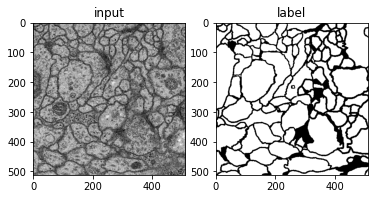

In [ ]:
## Library
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Data Cller
dir_data = '/content/drive/MyDrive/data' 

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

## train/test/val folder 
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

## 30 image mix 
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

## save triain image to npy 
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

## save valid image to npy
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

## save test image to npy 
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

## image visualize
plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()


In [ ]:
#DataLoader 
class Dataset(torch.utils.data.Dataset):

    def __init__(self,dir,transform = None):

        self.dir = dir
        self.transform = transform

        data_list = os.listdir(self.dir)

        lst_label = [i for i in data_list if i.startswith('label')]
        lst_input = [i for i in data_list if i.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input 

    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self,idx):

        label = np.load(os.path.join(self.dir,self.lst_label[idx]))
        input = np.load(os.path.join(self.dir,self.lst_input[idx]))

        label = label/255.0
        input = input/255.0 


        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)
        
        return data 


   


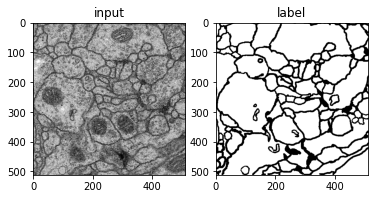

In [ ]:
dataset_train = Dataset(dir = dir_save_train)
data = dataset_train.__getitem__(0)
input = data['input']
label = data['label']

plt.subplot(122)
plt.imshow(label.reshape(512,512),cmap = 'gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(512,512),cmap = 'gray')
plt.title('input')
plt.show()

In [ ]:
pip install elasticdeform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 KB 11.0 MB/s eta 0:00:00


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
import numpy, imageio, elasticdeform
# Transform implement 
class ToTensor():
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization():
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip():
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

class ElasticTransform():
    def __call__(self,data):

        label, input = data['label'], data['input']
        label = elasticdeform.deform_random_grid(label, sigma=0.01, axis = (0,1))
        input = elasticdeform.deform_random_grid(input, sigma=0.01, axis = (0,1))
        data = {'label': label, 'input': input}
        return data


        

In [ ]:
# Saving Model
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## Calling Model 
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

In [ ]:
# Dataset,DataLoader
from torch.utils.data import DataLoader

# Setting Parameters 
lr = 1e-3
batch_size = 4
num_epoch = 20

base_dir = './drive/MyDrive/DACrew/unet'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")


# Transform and DataLoader 
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(),ElasticTransform(),ToTensor()])
#transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(),ToTensor()])
#transform = transform1

dataset_train = Dataset(dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = Dataset(dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = model1.to(device)

# Defining Loss function 
fn_loss = nn.BCEWithLogitsLoss().to(device)


# Setting Optimizer 
optim = torch.optim.Adam(net.parameters(), lr=lr)


num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)


fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# setting summarywriter for tensorboard 
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# train!!!
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

        
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        
        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()

TRAIN: EPOCH 0001 / 0020 | BATCH 0001 / 0006 | LOSS 0.7650
TRAIN: EPOCH 0001 / 0020 | BATCH 0002 / 0006 | LOSS 0.6869
TRAIN: EPOCH 0001 / 0020 | BATCH 0003 / 0006 | LOSS 0.6546
TRAIN: EPOCH 0001 / 0020 | BATCH 0004 / 0006 | LOSS 0.6287
TRAIN: EPOCH 0001 / 0020 | BATCH 0005 / 0006 | LOSS 0.6046
TRAIN: EPOCH 0001 / 0020 | BATCH 0006 / 0006 | LOSS 0.5800
VALID: EPOCH 0001 / 0020 | BATCH 0001 / 0001 | LOSS 0.6237
TRAIN: EPOCH 0002 / 0020 | BATCH 0001 / 0006 | LOSS 0.4631
TRAIN: EPOCH 0002 / 0020 | BATCH 0002 / 0006 | LOSS 0.4583
TRAIN: EPOCH 0002 / 0020 | BATCH 0003 / 0006 | LOSS 0.4417
TRAIN: EPOCH 0002 / 0020 | BATCH 0004 / 0006 | LOSS 0.4292
TRAIN: EPOCH 0002 / 0020 | BATCH 0005 / 0006 | LOSS 0.4213
TRAIN: EPOCH 0002 / 0020 | BATCH 0006 / 0006 | LOSS 0.4169
VALID: EPOCH 0002 / 0020 | BATCH 0001 / 0001 | LOSS 0.5654
TRAIN: EPOCH 0003 / 0020 | BATCH 0001 / 0006 | LOSS 0.3792
TRAIN: EPOCH 0003 / 0020 | BATCH 0002 / 0006 | LOSS 0.3771
TRAIN: EPOCH 0003 / 0020 | BATCH 0003 / 0006 | LOSS 0.37

In [ ]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)


result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

        
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0001 | LOSS 0.2279
AVERAGE TEST: BATCH 0001 / 0001 | LOSS 0.2279


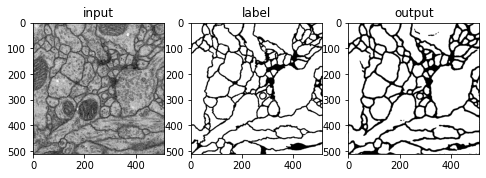

In [ ]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

#plot
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()


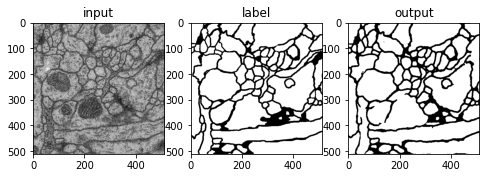

In [ ]:
id = 1

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

#plot
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()

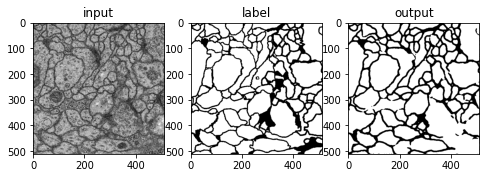

In [ ]:
id = 2

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

#plot
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()